# Sovrin StagingNet Example: Verify Presentation

## Before running this notebook you should have run through [Part 1](http://localhost:8888/notebooks/Part 1 - Getting Started.ipynb) and [Part 2](http://localhost:8888/notebooks/Part 2 - Issuer.ipynb) of this tutorial.

If unfamiliar with the present-proof protocol it is worth reading through the [aries-rfs](https://github.com/hyperledger/aries-rfcs/tree/master/features/0037-present-proof)`


## Note that you do not need to write a public DID to the ledger as a verifier.

## Import packages

In [1]:
!pip install termcolor
!pip install pillow
!pip install qrcode
from termcolor import colored,cprint

  Created wheel for termcolor: filename=termcolor-1.1.0-py3-none-any.whl size=4830 sha256=acb1b13e1e61fcfb1c0863c058e7df368186ed7017ef97899f311c45df18fa13
  Stored in directory: /root/.cache/pip/wheels/3f/e3/ec/8a8336ff196023622fbcb36de0c5a5c218cbb24111d1d4c7f2
Successfully built termcolor
     |████████████████████████████████| 2.2 MB 2.2 MB/s eta 0:00:01


## 1. Instatiate Controller for Verifiers's Agent

In [2]:
%autoawait
import time
import asyncio
from aries_basic_controller.aries_controller import AriesAgentController

WEBHOOK_HOST = "0.0.0.0"
WEBHOOK_PORT = 8052
WEBHOOK_BASE = ""
ADMIN_URL = "http://verifier-agent:8051"

# Based on the aca-py agent you wish to control
agent_controller = AriesAgentController(webhook_host=WEBHOOK_HOST, webhook_port=WEBHOOK_PORT,
                                       webhook_base=WEBHOOK_BASE, admin_url=ADMIN_URL)


IPython autoawait is `on`, and set to use `asyncio`


## 2. Register Listeners

Again @lohan lets tidy these up to be verifier specific only I think.

The handler should get called every time the controller receives a webhook with the topic present_proof, printing out the payload. The agent calls to this webhook every time it receives a present proof protocol message from another agent. 


In [3]:
loop = asyncio.get_event_loop()
loop.create_task(agent_controller.listen_webhooks())

def cred_handler(payload):
    print("Handle Credentials")
    exchange_id = payload['credential_exchange_id']
    state = payload['state']
    role = payload['role']
    attributes = payload['credential_proposal_dict']['credential_proposal']['attributes']
    print(f"Credential exchange {exchange_id}, role: {role}, state: {state}")
    print(f"Offering: {attributes}")
    
cred_listener = {
    "topic": "issue_credential",
    "handler": cred_handler
}

def messages_handler(payload):
    connection_id = payload["connection_id"]
    asyncio.get_event_loop().create_task(agent_controller.messaging.send_message(connection_id, "This is a response from Bob"))
    print("Handle message", payload, connection_id)


message_listener = {
    "handler": messages_handler,
    "topic": "basicmessages"
}

def connections_handler(payload):
    global STATE
    connection_id = payload["connection_id"]
    print("Connection message", payload, connection_id)
    STATE = payload['state']
    if STATE == 'active':
#         print('Connection {0} changed state to active'.format(connection_id))
        print(colored("Connection {0} changed state to active".format(connection_id), "red", attrs=["bold"]))


connection_listener = {
    "handler": connections_handler,
    "topic": "connections"
}

def proof_handler(payload):
    print("Handle present proof")
    print(payload)

proof_listener = {
    "topic": "present_proof",
    "handler": proof_handler
}

agent_controller.register_listeners([cred_listener,message_listener,connection_listener,proof_listener], defaults=True)



## 3. Make a connection with the Mobile SSI Wallet you used in [Part 2](http://localhost:8888/notebooks/Part 2 - Issuer.ipynb)

**You should have a credential stored in here from the previous notebook!**

Please download a mobile SSI wallet such as [Connect.me](https://connect.me/), [Trinsic](https://trinsic.id/trinsic-wallet/) or any other Aries compatible wallet.

## 4. Create a connection invitation to scan with the Mobile SSI Wallet

## 4a. Check for any existing connections

In [4]:
# Check for existing connections
connection = await agent_controller.connections.get_connections()
print("EXISTING CONNECTIONS")
for key, value in connection.items():
    for item in value:
        print('ConnectionID:', item['connection_id'], 'Status:',item['state'])

EXISTING CONNECTIONS


## 4b. Create an Invitation

In [5]:
# Create Invitation
invite = await agent_controller.connections.create_invitation()
connection_id = invite["connection_id"]
print("Connection ID", connection_id)
print("Invitation")
print(invite['invitation_url'])
inviteURL = invite['invitation_url']

Connection message {'state': 'invitation', 'connection_id': '0d9630cd-4deb-43d7-a4f1-a5513ca5869b', 'invitation_key': 'Aee27tW2MvaEeduHaJJyiyQYisLw9VnQRetFbmB9eB7U', 'accept': 'auto', 'routing_state': 'none', 'invitation_mode': 'once', 'created_at': '2020-09-16 13:39:30.326259Z', 'updated_at': '2020-09-16 13:39:30.326259Z', 'initiator': 'self'} 0d9630cd-4deb-43d7-a4f1-a5513ca5869b
Connection ID 0d9630cd-4deb-43d7-a4f1-a5513ca5869b
Invitation
https://3bb56e5f3644.ngrok.io?c_i=eyJAdHlwZSI6ICJkaWQ6c292OkJ6Q2JzTlloTXJqSGlxWkRUVUFTSGc7c3BlYy9jb25uZWN0aW9ucy8xLjAvaW52aXRhdGlvbiIsICJAaWQiOiAiOTQyMjRiNGQtYjZlMS00NWJiLTk1N2UtODc0NmRmNzk5YTZjIiwgInJlY2lwaWVudEtleXMiOiBbIkFlZTI3dFcyTXZhRWVkdUhhSkp5aXlRWWlzTHc5Vm5RUmV0RmJtQjllQjdVIl0sICJzZXJ2aWNlRW5kcG9pbnQiOiAiaHR0cHM6Ly8zYmI1NmU1ZjM2NDQubmdyb2suaW8iLCAibGFiZWwiOiAiVmVyaWZpZXIifQ==


## 4c. Generate QR Code to be scanned with Mobile SSI Wallet

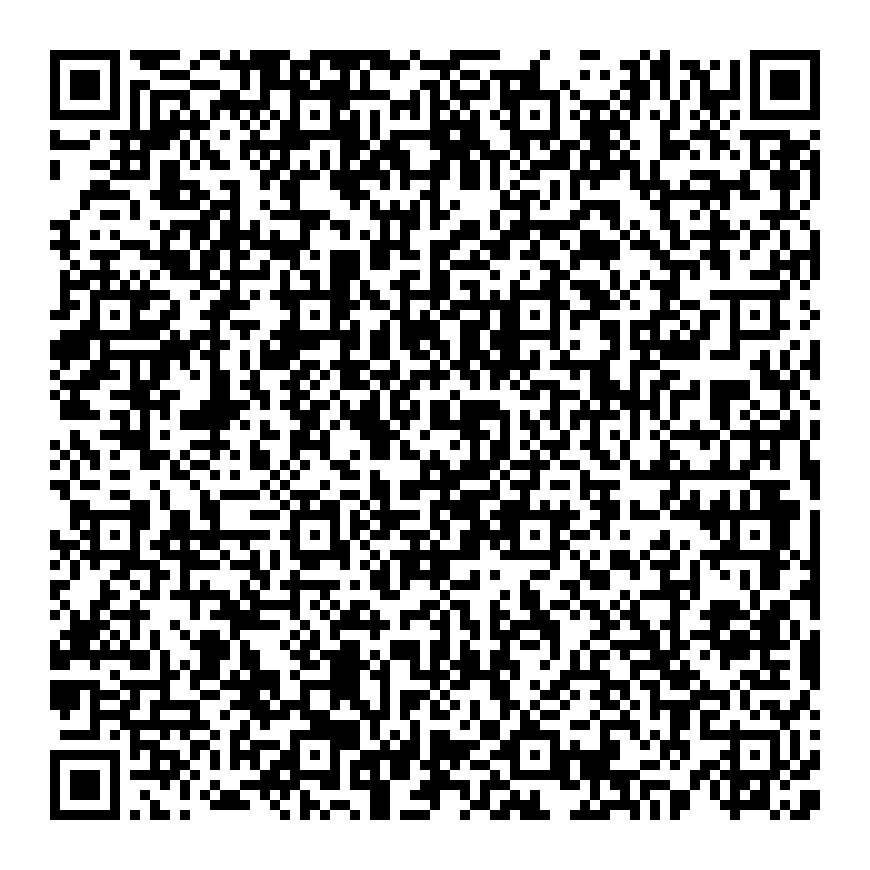

Connection message {'their_label': 'esatus Wallet', 'their_did': 'SFVjQ3CzjFHhAJtnE5FXzk', 'state': 'request', 'connection_id': '0d9630cd-4deb-43d7-a4f1-a5513ca5869b', 'invitation_key': 'Aee27tW2MvaEeduHaJJyiyQYisLw9VnQRetFbmB9eB7U', 'accept': 'auto', 'routing_state': 'none', 'invitation_mode': 'once', 'created_at': '2020-09-16 13:39:30.326259Z', 'updated_at': '2020-09-16 13:39:48.524132Z', 'initiator': 'self'} 0d9630cd-4deb-43d7-a4f1-a5513ca5869b
Connection message {'their_label': 'esatus Wallet', 'their_did': 'SFVjQ3CzjFHhAJtnE5FXzk', 'state': 'response', 'connection_id': '0d9630cd-4deb-43d7-a4f1-a5513ca5869b', 'invitation_key': 'Aee27tW2MvaEeduHaJJyiyQYisLw9VnQRetFbmB9eB7U', 'accept': 'auto', 'my_did': 'XrSKDTxjWq1aPWF1RkiPNG', 'routing_state': 'none', 'invitation_mode': 'once', 'created_at': '2020-09-16 13:39:30.326259Z', 'updated_at': '2020-09-16 13:39:48.579572Z', 'initiator': 'self'} 0d9630cd-4deb-43d7-a4f1-a5513ca5869b


In [6]:
import qrcode
# Link for connection invitation
input_data = inviteURL
# Creating an instance of qrcode
qr = qrcode.QRCode(
        version=1,
        box_size=10,
        border=5)
qr.add_data(input_data)
qr.make(fit=True)
img = qr.make_image(fill='black', back_color='white')
img.save('verifier_agent_invite_QRcode.png')

from IPython.display import Image
Image(width=400, filename='./verifier_agent_invite_QRcode.png')

## 4d. Check if established connection is in active state

In [7]:
import time

# print('Current state for ConnectionId {} is {}'.format(connection_id,STATE))
print(colored("Current state for ConnectionId {} is {}".format(connection_id,STATE), "magenta", attrs=["bold"]))
while STATE != 'active':
#     print('ConnectionId {0} is not in active state yet'.format(connection_id))
    print(colored("ConnectionId {0} is not in active state yet".format(connection_id), "yellow", attrs=["bold"]))
    trust_ping = await agent_controller.messaging.trust_ping(connection_id,'hello!')
#     print('Trust ping send to ConnectionId {0} to activate connection'.format(trust_ping))
    print(colored("Trust ping send to ConnectionId {0} to activate connection".format(trust_ping), "blue", attrs=["bold"]))
    time.sleep(5)
    
# print('ConnectionId: {0} is now active. Continue with notebook'.format(connection_id))
print(colored("ConnectionId: {0} is now active. Continue with notebook".format(connection_id), "green", attrs=["bold"]))


Current state for ConnectionId 0d9630cd-4deb-43d7-a4f1-a5513ca5869b is response
ConnectionId 0d9630cd-4deb-43d7-a4f1-a5513ca5869b is not in active state yet
Trust ping send to ConnectionId {'thread_id': '010c2126-09f1-4331-a90d-c55f1a5fa59e'} to activate connection
ConnectionId 0d9630cd-4deb-43d7-a4f1-a5513ca5869b is not in active state yet
Connection message {'their_label': 'esatus Wallet', 'their_did': 'SFVjQ3CzjFHhAJtnE5FXzk', 'state': 'active', 'connection_id': '0d9630cd-4deb-43d7-a4f1-a5513ca5869b', 'invitation_key': 'Aee27tW2MvaEeduHaJJyiyQYisLw9VnQRetFbmB9eB7U', 'accept': 'auto', 'my_did': 'XrSKDTxjWq1aPWF1RkiPNG', 'routing_state': 'none', 'invitation_mode': 'once', 'created_at': '2020-09-16 13:39:30.326259Z', 'updated_at': '2020-09-16 13:39:59.790739Z', 'initiator': 'self'} 0d9630cd-4deb-43d7-a4f1-a5513ca5869b
Connection 0d9630cd-4deb-43d7-a4f1-a5513ca5869b changed state to active
Trust ping send to ConnectionId {'thread_id': '46f5557e-5cb9-4b66-947c-5b57710223a1'} to activate 

## 5. Send Proof Request to Identity Holder Mobile Wallet

## 5a. Generate Proof Request

Note how the verifier has restricted the proof request to only include those attributes issued by the issuing DID.

@Lohan -> I don't like that we have to instantiate the issuer_agent_controller to fetch this DID. I think there must be a better way. Perhaps asking users to copy across the DID from part 1? or we could restrict on the schema id?

In [8]:
from aries_basic_controller.aries_controller import AriesAgentController
    
WEBHOOK_HOST = "0.0.0.0"
WEBHOOK_PORT = 8022
WEBHOOK_BASE = ""
ADMIN_URL = "http://issuer-agent:8021"

# Based on the aca-py agent you wish to control
issuer_agent_controller = AriesAgentController(webhook_host=WEBHOOK_HOST, webhook_port=WEBHOOK_PORT,
                                       webhook_base=WEBHOOK_BASE, admin_url=ADMIN_URL)

response = await issuer_agent_controller.wallet.get_public_did()
print(response)
issuer_did = response["result"]["did"]

print("Request proof of Name and Age range from Identity Holder")
#Set some variables

revocation = False
SELF_ATTESTED = True
exchange_tracing = False

#Enable this to ask for attributes to identity a user
req_attrs = [
    {"name": "name", "restrictions": [{"issuer_did": issuer_did}]},
    {"name": "skill", "restrictions": [{"issuer_did": issuer_did}]},
]

if revocation:
    req_attrs.append(
        {
            "name": "skill",
            "restrictions": [{"issuer_did": agent.did}],
            "non_revoked": {"to": int(time.time() - 1)},
        },
    )

if SELF_ATTESTED:
    # test self-attested claims
    req_attrs.append({"name": "country"},)

#Set predicates for Zero Knowledge Proofs
req_preds = [
    # test zero-knowledge proofs
    {
        "name": "age",
        "p_type": ">=",
        "p_value": 21,
        "restrictions": [{"issuer_did": issuer_did}],
    }
]

indy_proof_request = {
    "name": "Proof of Personal Information",
    "version": "1.0",
    "requested_attributes": {
        f"0_{req_attr['name']}_uuid":
        req_attr for req_attr in req_attrs
    },
    "requested_predicates": {
        f"0_{req_pred['name']}_GE_uuid":
        req_pred for req_pred in req_preds
    },
}

if revocation:
    indy_proof_request["non_revoked"] = {"to": int(time.time())}

#proof_request = indy_proof_request
exchange_tracing_id = exchange_tracing
proof_request_web_request = {
    "connection_id": connection_id,
    "proof_request": indy_proof_request,
    "trace": exchange_tracing,
}

{'result': {'did': '826BrciniTTh7FRMFyrPWR', 'verkey': '4psuB2xY6kp8y4784Xs92Ao8Kazi74T64u5GADGKovCv', 'public': True}}
Request proof of Name and Age range from Identity Holder


### 5b. Send the proof request to Identity Holder

Identity Holder is identified through the connection_id

In [9]:
response = await agent_controller.proofs.send_request(proof_request_web_request)
print(response)
presentation_exchange_id = response['presentation_exchange_id']
print("\n")
print(presentation_exchange_id)


{'role': 'verifier', 'state': 'request_sent', 'connection_id': '0d9630cd-4deb-43d7-a4f1-a5513ca5869b', 'presentation_exchange_id': '53a604ac-b1d3-464e-a4ce-16628e44555e', 'presentation_request': {'name': 'Proof of Personal Information', 'version': '1.0', 'requested_attributes': {'0_name_uuid': {'name': 'name', 'restrictions': [{'issuer_did': '826BrciniTTh7FRMFyrPWR'}]}, '0_skill_uuid': {'name': 'skill', 'restrictions': [{'issuer_did': '826BrciniTTh7FRMFyrPWR'}]}, '0_country_uuid': {'name': 'country'}}, 'requested_predicates': {'0_age_GE_uuid': {'name': 'age', 'p_type': '>=', 'p_value': 21, 'restrictions': [{'issuer_did': '826BrciniTTh7FRMFyrPWR'}]}}, 'nonce': '867066356444314349495390'}, 'thread_id': 'a8018567-1c2d-411a-9195-9c21a206e436', 'auto_present': False, 'trace': False, 'presentation_request_dict': {'@type': 'did:sov:BzCbsNYhMrjHiqZDTUASHg;spec/present-proof/1.0/request-presentation', '@id': 'a8018567-1c2d-411a-9195-9c21a206e436', 'request_presentations~attach': [{'@id': 'libin

## 6. Verify Proof Presentation

This is checking the signatures on the credentials presented against the credential schema and definition id stored and resolvable on the ledger. It is a bit of a big complicated object, so we show the common pattern for breaking it down, checking it's verified and accessing the data that has been presented.

In [10]:
verify = await agent_controller.proofs.verify_presentation(presentation_exchange_id)
print(verify)

{'role': 'verifier', 'state': 'verified', 'connection_id': '0d9630cd-4deb-43d7-a4f1-a5513ca5869b', 'presentation_exchange_id': '53a604ac-b1d3-464e-a4ce-16628e44555e', 'presentation_request': {'name': 'Proof of Personal Information', 'version': '1.0', 'requested_attributes': {'0_name_uuid': {'name': 'name', 'restrictions': [{'issuer_did': '826BrciniTTh7FRMFyrPWR'}]}, '0_skill_uuid': {'name': 'skill', 'restrictions': [{'issuer_did': '826BrciniTTh7FRMFyrPWR'}]}, '0_country_uuid': {'name': 'country'}}, 'requested_predicates': {'0_age_GE_uuid': {'name': 'age', 'p_type': '>=', 'p_value': 21, 'restrictions': [{'issuer_did': '826BrciniTTh7FRMFyrPWR'}]}}, 'nonce': '867066356444314349495390'}, 'verified': 'true', 'thread_id': 'a8018567-1c2d-411a-9195-9c21a206e436', 'auto_present': False, 'trace': False, 'presentation_request_dict': {'@type': 'did:sov:BzCbsNYhMrjHiqZDTUASHg;spec/present-proof/1.0/request-presentation', '@id': 'a8018567-1c2d-411a-9195-9c21a206e436', 'request_presentations~attach':

Handle present proof
{'role': 'verifier', 'state': 'verified', 'connection_id': '0d9630cd-4deb-43d7-a4f1-a5513ca5869b', 'presentation_exchange_id': '53a604ac-b1d3-464e-a4ce-16628e44555e', 'presentation_request': {'name': 'Proof of Personal Information', 'version': '1.0', 'requested_attributes': {'0_name_uuid': {'name': 'name', 'restrictions': [{'issuer_did': '826BrciniTTh7FRMFyrPWR'}]}, '0_skill_uuid': {'name': 'skill', 'restrictions': [{'issuer_did': '826BrciniTTh7FRMFyrPWR'}]}, '0_country_uuid': {'name': 'country'}}, 'requested_predicates': {'0_age_GE_uuid': {'name': 'age', 'p_type': '>=', 'p_value': 21, 'restrictions': [{'issuer_did': '826BrciniTTh7FRMFyrPWR'}]}}, 'nonce': '867066356444314349495390'}, 'verified': 'true', 'thread_id': 'a8018567-1c2d-411a-9195-9c21a206e436', 'auto_present': False, 'trace': False, 'presentation_request_dict': {'@type': 'did:sov:BzCbsNYhMrjHiqZDTUASHg;spec/present-proof/1.0/request-presentation', '@id': 'a8018567-1c2d-411a-9195-9c21a206e436', 'request_p

### Verifying the State

Once verified through the agent framework api, the state should be 'verified', otherwise the presentation is invalid.

In [23]:
print(verify['state'])
print(verify['state'] == 'verified')

verified
True


### Accessing the Revealed Attributes

In [19]:
print(verify['presentation'])
print(verify['presentation']['requested_proof'])

for (name, val) in verify['presentation']['requested_proof']['revealed_attrs'].items():
    print(name)
    print(val)
    ## This is the actual data that you want. It's a little hidden
    print(val['raw'])


verified
{'revealed_attrs': {'0_skill_uuid': {'sub_proof_index': 0, 'raw': 'researcher', 'encoded': '24214165878429772374367858032287880675266648921286067519661391650938186682695'}, '0_name_uuid': {'sub_proof_index': 0, 'raw': 'Bob', 'encoded': '93006290325627508022776103386395994712401809437930957652111221015872244345185'}}, 'self_attested_attrs': {'0_country_uuid': 'UK'}, 'unrevealed_attrs': {}, 'predicates': {'0_age_GE_uuid': {'sub_proof_index': 0}}}
0_skill_uuid
{'sub_proof_index': 0, 'raw': 'researcher', 'encoded': '24214165878429772374367858032287880675266648921286067519661391650938186682695'}
researcher
0_name_uuid
{'sub_proof_index': 0, 'raw': 'Bob', 'encoded': '93006290325627508022776103386395994712401809437930957652111221015872244345185'}
Bob


### Accessing self-attested attributes

In [22]:
for (name, val) in verify['presentation']['requested_proof']['self_attested_attrs'].items():
    print(name)
    ## Slightly different for self attested attrs
    print(val)

0_country_uuid
UK


## @lohan do we say something about predicates. Not sure exactly what lol.

## End of Tutorial

Be sure to terminate the controller so you can run another tutorial.

In [24]:
response = await issuer_agent_controller.terminate()
print(response)
response = await agent_controller.terminate()
print(response)

None
None
